In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']   #显示中文
plt.rcParams['axes.unicode_minus']=False       #显示负号
import os

In [2]:
import pickle 
# 保存
with open('datahd.pkl', 'rb') as f:
    data = pickle.load(f)

# 数据部分

In [3]:
from sklearn.preprocessing import MinMaxScaler
scaler_train_x = MinMaxScaler(feature_range=(-1, 1))
scaler_train_y = MinMaxScaler(feature_range=(-1, 1))
scaler_x = MinMaxScaler(feature_range=(-1, 1))

In [4]:
import numpy as np

def create_sliding_windows(seq_data, look_back=1, pre_l=1,mode='train'):
    X, y = [], []
    scaler_list = []
    for i in range(len(seq_data) - look_back - pre_l + 1):
        # 取出当前窗口的输入数据
        window_x = seq_data[i:(i + look_back)]
        # 取出当前窗口对应的目标数据
        window_y = seq_data[(i + look_back):(i + look_back + pre_l)]
        if mode == 'train':
            window_x = scaler_train_x.fit_transform(window_x)
            window_y = scaler_train_y.fit_transform(window_y)
            X.append(window_x)
            y.append(window_y)
        if mode=='test':
            scaler_y = MinMaxScaler(feature_range=(-1, 1))
            window_x = scaler_x.fit_transform(window_x)
            window_y = scaler_y.fit_transform(window_y)
            X.append(window_x)
            y.append(window_y)
            scaler_list.append(scaler_y)
    if mode=='train':
        return np.array(X), np.array(y)
    if mode=='test':
        return np.array(X), np.array(y),scaler_list


In [5]:
train_size = int(0.8*len(data))

In [6]:

LOOK_BACK = 3  ############################################################ 这里输入窗口
PREL = 5
DIM = 2
X_train_list = []
y_train_list = []
for d in data[:train_size]:
    X_train, y_train = create_sliding_windows(d.values, look_back=LOOK_BACK, pre_l=PREL)
    X_train_list.append(X_train)
    y_train_list.append(y_train)
X_train = np.concatenate(X_train_list, axis=0)
y_train = np.concatenate(y_train_list, axis=0)


## 模型部分

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
# 划分数据集
x_train,x_test,y_train,y_test = train_test_split(X_train,y_train,test_size=0.2,random_state=42)
train_dataset = TensorDataset(torch.tensor(x_train,dtype=torch.float32),torch.tensor(y_train,dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(x_test,dtype=torch.float32),torch.tensor(y_test,dtype=torch.float32))
train_loader = DataLoader(train_dataset,batch_size=64,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=64,shuffle=False)


In [8]:
import torch
import torch.nn as nn

class Predictor(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=1, dropout=0):
        super(Predictor, self).__init__()
        
        # LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout)
        
        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Linear(64, PREL * DIM)
        )
        
        # Projection layer
        self.pro = nn.Linear(DIM, input_dim)

    def forward(self, x):
        # Project the input to the desired dimensionality
        x = self.pro(x)
        
        # Pass through the LSTM
        lstm_out, _ = self.lstm(x)  # lstm_out shape: (batch_size, sequence_length, hidden_dim)
        
        # Take the last time step's output (or you can use all time steps if needed)
        lstm_out = lstm_out[:, -1, :]  # Shape: (batch_size, hidden_dim)
        
        # Pass through the fully connected layers
        fc_out = self.fc(lstm_out)  # Shape: (batch_size, PREL * DIM)
        
        # Reshape to (batch_size, PREL, DIM)
        fc_out = fc_out.view(fc_out.size(0), PREL, DIM)
        
        return fc_out

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# 初始化模型、优化器和损失函数
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Predictor(input_dim=1,hidden_dim=64).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()


In [10]:
# 计算模型的总参数数量
total_params = sum(p.numel() for p in model.parameters())

# 计算可训练的参数数量
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"总参数数量: {total_params}")
print(f"可训练参数数量: {trainable_params}")

总参数数量: 21965
可训练参数数量: 21965


Epoch [1/200], Train Loss: 0.3538, Val Loss: 0.2539, MAE: 0.2880
Epoch [2/200], Train Loss: 0.2539, Val Loss: 0.2533, MAE: 0.2819
Epoch [3/200], Train Loss: 0.2529, Val Loss: 0.2519, MAE: 0.2851
Epoch [4/200], Train Loss: 0.2525, Val Loss: 0.2534, MAE: 0.2750
Epoch [5/200], Train Loss: 0.2524, Val Loss: 0.2528, MAE: 0.2799
Epoch [6/200], Train Loss: 0.2523, Val Loss: 0.2521, MAE: 0.2798
Epoch [7/200], Train Loss: 0.2520, Val Loss: 0.2508, MAE: 0.2774
Epoch [8/200], Train Loss: 0.2520, Val Loss: 0.2511, MAE: 0.2804
Epoch [9/200], Train Loss: 0.2519, Val Loss: 0.2512, MAE: 0.2824
Epoch [10/200], Train Loss: 0.2517, Val Loss: 0.2512, MAE: 0.2766
Epoch [11/200], Train Loss: 0.2516, Val Loss: 0.2510, MAE: 0.2778
Epoch [12/200], Train Loss: 0.2516, Val Loss: 0.2504, MAE: 0.2760
Epoch [13/200], Train Loss: 0.2516, Val Loss: 0.2514, MAE: 0.2804
Epoch [14/200], Train Loss: 0.2515, Val Loss: 0.2517, MAE: 0.2749
Epoch [15/200], Train Loss: 0.2514, Val Loss: 0.2518, MAE: 0.2812
Epoch [16/200], Tra

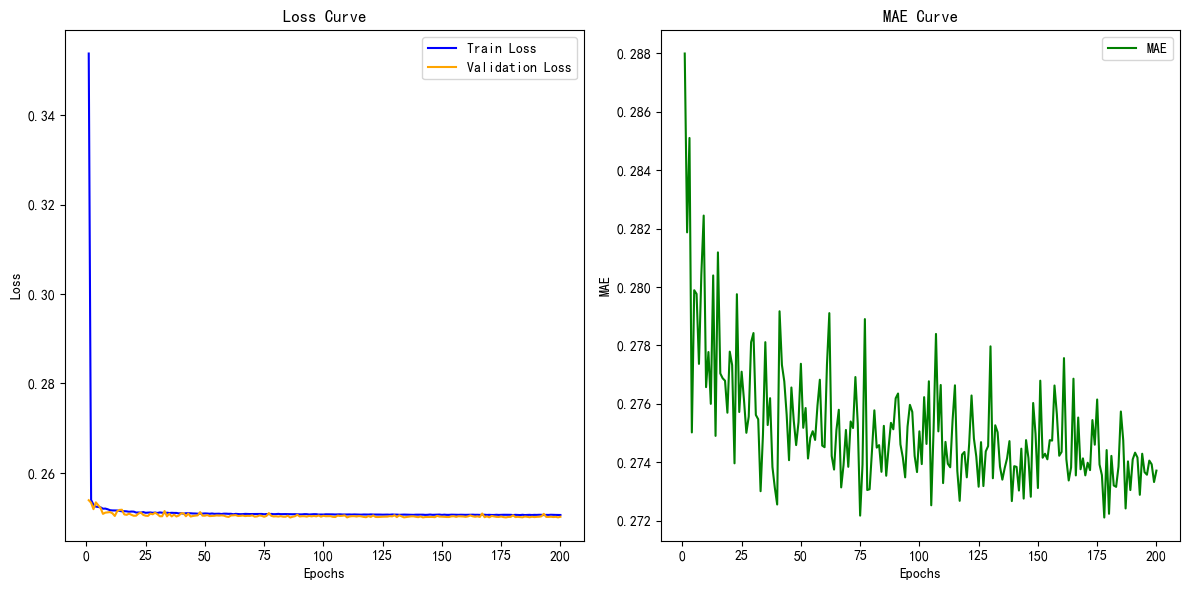

In [11]:

# 训练和验证过程
train_losses = []
val_losses = []
mae_scores = []

def train_model(epochs):
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # 验证集评估
        val_loss, mae_score = validate_model()
        val_losses.append(val_loss)
        mae_scores.append(mae_score)

        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, MAE: {mae_score:.4f}")

def validate_model():
    model.eval()
    val_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()

            all_preds.append(outputs.cpu().numpy())
            all_labels.append(batch_y.cpu().numpy())

    val_loss /= len(test_loader)
    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    mae = mean_absolute_error(all_labels.reshape(-1), all_preds.reshape(-1))
    return val_loss, mae

# 绘制损失和MAE曲线
def plot_metrics():
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 6))

    # 绘制训练和验证损失
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss", color="blue")
    plt.plot(epochs, val_losses, label="Validation Loss", color="orange")
    plt.title("Loss Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # 绘制MAE曲线
    plt.subplot(1, 2, 2)
    plt.plot(epochs, mae_scores, label="MAE", color="green")
    plt.title("MAE Curve")
    plt.xlabel("Epochs")
    plt.ylabel("MAE")
    plt.legend()

    plt.tight_layout()
    plt.show()

# 运行训练和绘图
if __name__ == "__main__":
    epochs = 200  # 设置训练轮数
    train_model(epochs)
    plot_metrics()

#### 测试

In [12]:
Test_df = data[train_size:]

In [13]:
X_test_list = []  
y_test_list = []
y_test_scaler_list = []
for d in Test_df:
    X_test, y_test,s = create_sliding_windows(d.values, look_back=LOOK_BACK, pre_l=PREL,mode='test')
    X_test_list.append(X_test)
    y_test_list.append(y_test)
    y_test_scaler_list.append(s)


In [14]:
pred_results = {}
idx = 0
for inp,ytrue,scalers in zip(X_test_list,y_test_list,y_test_scaler_list):
    with torch.no_grad():
        inp = torch.tensor(inp,dtype=torch.float32).to(device)
        out = model(inp)
        out = out.cpu().numpy()
        pred_list = []
        true_list = []
        for i in range(out.shape[0]):
            scaler = scalers[i]
            p_ = scaler.inverse_transform(out[i])
            true_ = scaler.inverse_transform(ytrue[i])
            pred_list.append(p_)
            true_list.append(true_)
        pred_list = np.array(pred_list)
        true_list = np.array(true_list)
    pred_results[idx] = {'ytrue':true_list,'yhat':pred_list}
    idx+=1
with open('lstm_pred_results.pkl','wb') as f:
    pickle.dump(pred_results,f)